In [67]:
import pandas as pd
import numpy as np
import os, glob
import matplotlib.pyplot as plt
from collections import deque
from itertools import combinations
from helper_funcs import bucket_remap,process_board,get_attributes

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns',None)

class hl_model():
   
    def __init__(self,exp_dir,rules):
        # Gather data associated with experiment
        self.data_import(exp_dir,rules)

        # Model configuration
        # List of features to be used for the underlying models
        #self.model_features = ['shape','color','row','col','quadrant','cell','bucket1','bucket2','bucket3','bucket4']
        self.model_features = ['shape','color','cell']
        # Types of feature combinations to be used (1->unary, 2->binary combinations, etc.)
        self.combination_types = [1]
        #self.init_models()
    
    # Utility for returning a tuple of all feature dimensions in a tuple of features
    def calc_dim(self,feat_arr):
        dims = tuple(self.feature_info[feat]['input_space'] for feat in feat_arr)
        return dims

    # In the RL model, much of this information is handled in the environment class
    def init_env_information(self):
        # Store all information about how to process each feature in following dictionary
        self.feature_info = {'shape':{'input_space':4,'col_name':'shape_ind'},
                        'color':{'input_space':4, 'col_name':'color_ind'},
                    #    'move_row':{'input_space':self.board_size, 'func':get_row,'reference':1},
                    #    'move_col':{'input_space':self.board_size, 'func':get_col,'reference':1},
                    #    'row':{'input_space':self.board_size, 'func':get_row,'reference':0},
                    #    'col':{'input_space':self.board_size, 'func':get_col,'reference':0},
                    #    'quadrant':{'input_space':4,'col_name':'quad_ind'},
                        'cell':{'input_space':36,'col_name':'cell_ind'}}
                    #    'bucket1':{'input_space':self.bucket_space+1,'func':get_bucket,'reference':1},
                    #    'bucket2':{'input_space':(self.bucket_space+1)**2,'func':get_bucket,'reference':2},
                    #    'bucket3':{'input_space':(self.bucket_space+1)**3,'func':get_bucket,'reference':3},
                    #    'bucket4':{'input_space':(self.bucket_space+1)**4,'func':get_bucket,'reference':4}}

        # Set up lists for storing past actions and board states
        self.reduced_move_list=deque([],50)
        self.board_list=deque([],50)

    # Import relevant player files
    def data_import(self,exp_dir,rules):
        # Initialize list for concatenating player records
        df_list =[]
        # Create a list containing all csv's in the given directory
        csv_list = glob.glob("**/*.csv",root_dir=exp_dir, recursive=True)

        # Loop over the files
        for item in csv_list[:4]:
            # Construct the import path and read data
            import_path = os.path.join(exp_dir,item)
            df = pd.read_csv(import_path)

            # Only work with data from a player's first encounter with the game
            series_num = df['seriesNo'].unique()[0]
            if series_num != 0:
                continue

            # Check the contained rules for multiple rules/players
            rules = df["#ruleSetName"].unique()
            player = df['playerId'].unique()
            if len(player)>1:
                print('------ERROR-----')
                print("File contains more than one player: ",import_path)
                print('----------------')
                break
            if len(rules)>1:
                print('------ERROR-----')
                print("Error reading the rules, multiple rules in file: ",import_path)
                print('----------------')
                break
            
            # Get rid of finger slips (assumed when the player grabs a movable piece but misses putting it into a bucket)
            finger_slips = (df.code == 0)&(df.bx.isna())&(df.by.isna())
            df = df[~finger_slips]
            # Reset index immediately
            df.reset_index(drop=True,inplace=True)
            # Set the move number to be the corrected index
            df['move']=df.index
            # Simplify output code to errors
            df['err']=df.apply(lambda row: 0 if row.code==0 else 1, axis=1)
            df['cumulative_err']=df.err.cumsum()

            # Add processed columns
            df['bucket']=df.copy().apply(lambda x: bucket_remap(x['by'],x['bx']),axis=1)
            df['proc_board']=df.copy().apply(lambda x: process_board(x['board']),axis=1)
            df[['shape','color','shape_ind','color_ind','id','cell','cell_ind']]=df.copy().apply(lambda x: get_attributes(x['proc_board'],x['y'],x['x']),axis=1,result_type='expand')
            # df[['shape0','shape1','shape2','shape3','color0','color1','color2','color3',
            #     'c1','c2','c3','c4','c5','c6','c7','c8','c9','c10','c11','c12',
            #     'c13','c14','c15','c16','c17','c18','c19','c20','c21','c22','c23','c24',
            #     'c25','c26','c27','c28','c29','c30','c31','c32','c33','c34','c35','c36']] = df.copy().apply(lambda x:calc_availability(x['proc_board'],shape_order,color_order),axis=1,result_type='expand')

            # Column cleanup
            df.rename(columns = {'orderInSeries':'episode','playerId':'player'},inplace=True)
            df.drop(columns=['#ruleSetName','seriesNo','precedingRules','timestamp',
                             'episodeId','experimentPlan','trialListId','board','p0','by','bx',
                             'moveNo'],axis=1,inplace=True)
            
            df_list.append(df)

            # Set for debugging
            self.debug_df = df.copy()

        # Concatenate into a single dataframe
        self.main_df = pd.concat(df_list,verify_integrity=True,ignore_index=True)

    def init_models(self):

        # Set up information about the environment
        self.init_env_information()

        # Initialize a list of all feature combinations to be used and populate iteratively using the combinations tool
        # Result will be a list of tuples of feature strings
        self.feature_combinations = []
        for r in self.combination_types:
            self.feature_combinations.extend(combinations(self.model_features,r))
        
        # Construct a list of models, each of which is constructed with a feature tuple and a dimension tuple
        self.models=[human_bandit_model(feat_arr,self.calc_dim(feat_arr),self.get_col(feat_arr)) for feat_arr in self.feature_combinations]

    # Debugging utility for presenting models and associated q values
    def present_models(self):
        for model in self.models:
            print(model.feats,model.feat_dims)
            print(model.q_values)

    def get_col(self,feat_arr):
        cols = tuple(self.feature_info[feat]['col_name'] for feat in feat_arr)
        return cols

    def player_train(self,player):
        # Train on a player's experience
        df = self.main_df.query("player==@player").copy()
        preds=[]
        bad_preds = []
        # Initialize models for this player
        self.init_models()

        # Loop over the rows of this player's experience
        for index,row in df.iterrows():
            # Perform prediction
            credibilities = [model.return_credibility() for model in self.models]
            best = np.argmax(credibilities)
            best_model = self.models[best]
            state,action,reward = best_model.proc_row(row)
            if best_model.q_values[state,action]==best_model.correct:
                preds.append(2)
            elif best_model.q_values[state,action]==best_model.init_q_value:
                if best_model.q_values[state,:].max()==best_model.init_q_value:
                    preds.append(1)
                else:
                    preds.append(0)
            else:
                preds.append(-1)
            # Process row
            for model in self.models:
                state,action,reward = model.proc_row(row)
                model.update(state,action,reward)
        for model in self.models:
            print(model.feats,model.return_credibility())
        fig,ax = plt.subplots(figsize=(8,5))
        ax.scatter(range(len(preds)),preds)
        ax.set_ylim([-1.5,2.5])

    def experiment_train(self):
        # Establish player list
        players = self.main_df.player.unique()

        # Loop over the players
        for player in players:
            print("Experience for player {}".format(player))
            self.player_train(player)

    def select_action(self,states):
        pass
    
    def get_credibilities(self):
        pass

class human_bandit_model():
    def __init__(self,feats,dims,cols):
        # Reward scheme
        self.init_q_value = 0
        self.correct = 1
        self.incorrect = -1

        # Establish rolling memory queues for each model with configurable memory
        self.memory_horizon = 10
        self.memory=deque([],self.memory_horizon)

        # Set up model features
        self.feats = feats
        self.cols = cols
        self.feat_dims = dims
        self.in_dim, self.out_dim = np.prod(self.feat_dims), 4
        self.q_values = np.full((self.in_dim,self.out_dim),self.init_q_value,dtype=np.int8)

        # Initialize model credibility
        self.credibility=0
    
    def return_credibility(self):
        return self.credibility

    def return_qvals(self):
        return np.copy(self.q_values)
        
    # Process the model's memory into the current rolling q-table
    def proc_qtable(self):
        # Reset the q-table
        self.q_values = np.full((self.in_dim,self.out_dim),self.init_q_value,dtype=np.int8)

        # Iterate over memory tuples and update q-table
        for (state,action,reward) in self.memory:
            self.q_values[state,action]=reward

    # Process credibility 
    def proc_cred(self,state,action):
        piece_q = self.q_values[state,:]
        chosen_q = self.q_values[state,action]

        if chosen_q==self.correct or (chosen_q==self.init_q_value and piece_q.max()==self.init_q_value):
            self.credibility+=1/self.in_dim
        else:
            self.credibility-=1/self.in_dim

    # Process the current row of the human's experience
    def proc_row(self,row):
        # Get the tuple of states (state for each feature before raveled into single state)
        states = tuple(row[col] for col in self.cols)
        # Process state,action,reward
        state = np.ravel_multi_index(states,self.feat_dims)
        action = row.bucket
        reward = self.incorrect if row.err else self.correct
        return (state,action,reward)
    
    def update(self,state,action,reward):
        # Process credibility
        self.proc_cred(state,action)
        # Add tuple to memory
        self.memory.append((state,action,reward))
        # Process the model's q-table based on the current rolling memory
        self.proc_qtable()

In [65]:
exp_path = "/Users/eric/data_analysis/ambiguity4/ep/1_1_color_3m_cua"
rules = ["1_1_color_3m_cua"]
model = hl_model(exp_path,rules)
model.main_df.head()

,player,episode,y,x,code,move,err,cumulative_err,bucket,proc_board,shape,color,shape_ind,color_ind,id,cell,cell_ind
0,A23G1L7KYHK9F2,0,6,1,0,0,0,0,0,"[{'id': 13438, 'color': 'RED', 'shape': 'CIRCL...",STAR,RED,3,0,13446,31,30
1,A23G1L7KYHK9F2,0,1,1,0,1,0,0,3,"[{'id': 13438, 'color': 'RED', 'shape': 'CIRCL...",CIRCLE,RED,1,0,13438,1,0
2,A23G1L7KYHK9F2,0,1,5,4,2,1,1,2,"[{'id': 13439, 'color': 'YELLOW', 'shape': 'SQ...",SQUARE,GREEN,2,3,13440,5,4
3,A23G1L7KYHK9F2,0,4,5,0,3,0,1,1,"[{'id': 13439, 'color': 'YELLOW', 'shape': 'SQ...",CIRCLE,YELLOW,1,2,13444,23,22
4,A23G1L7KYHK9F2,0,1,5,0,4,0,1,0,"[{'id': 13439, 'color': 'YELLOW', 'shape': 'SQ...",SQUARE,GREEN,2,3,13440,5,4


Experience for player A23G1L7KYHK9F2
('shape',) 7.5
('color',) 10.0
('cell',) 1.7777777777777752
Experience for player A7VA2Y4H6U31O
('shape',) 1.75
('color',) 11.25
('cell',) 1.6388888888888868
Experience for player A2LU7CL50XLYJO
('shape',) 0.5
('color',) 12.5
('cell',) 1.2222222222222217
Experience for player A1ZD9SJXQ9C6EW
('shape',) 0.5
('color',) 7.5
('cell',) 1.0000000000000002


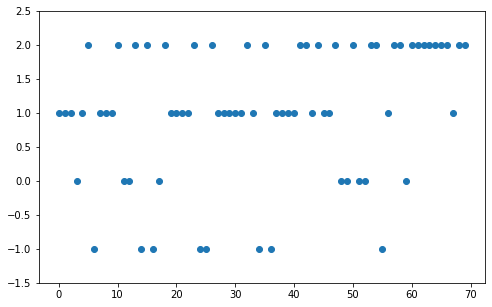

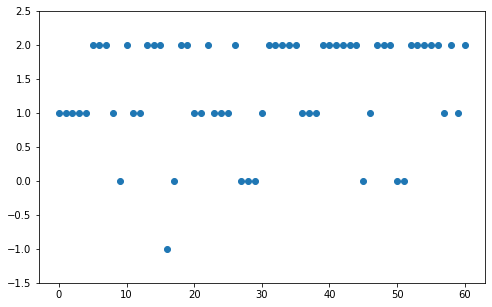

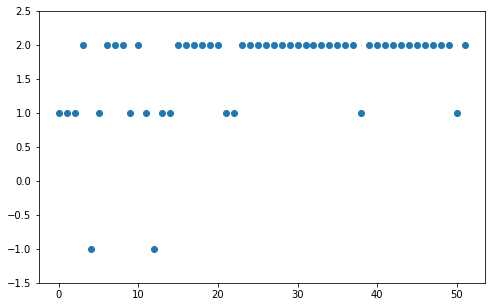

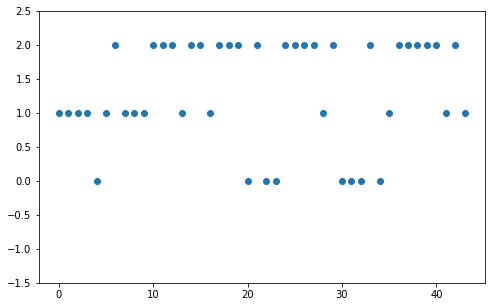

In [66]:
model.experiment_train()
#display(model.main_df)